## GroupWithNoName EEG Data Processing

### Event Codes
33024 - Universal for key release <br>
33025 - a (start) key press <br>
33027 - e (waldo found) key press

### Imports

In [265]:
import pandas as pd
import numpy as np
import os
from os import listdir
from os.path import isfile, join, isdir

### Known Variables

In [699]:
sampling_rate = 512.0
epoch_length = 7.0

### Helper Functions

In [694]:
#
# Cleans a given raw openvibe dataframe
#
def clean_trial(trial):
    
    #drop unwanted columns
    trial = trial.drop(columns=['Event Duration'])
    trial = trial.drop(columns=['Event Date'])
    trial = trial.drop(columns=['Electrode'])
    
    #remove nans and key releases
    trial.loc[trial['Event Id'] == 33024,  'Event Id'] = 0
    trial.loc[trial['Event Id'].isnull(),  'Event Id'] = 0
    
    #shift df to start on start key press
    start_index = trial.index[trial['Event Id'] == 33025]
    trial = trial[(start_index[0]+1):].reset_index()
    trial = trial.drop(columns=['index'])
    
    #reset epoch to begin at 0/drop epoch column
    #trial = trial.drop(columns=['Epoch'])
    trial['Epoch']-=trial['Epoch'][0]
    
    #reset time to begin at 0
    trial['Time:512Hz']-=trial['Time:512Hz'][0]
    
    #set found waldo id 1
    trial.loc[trial['Event Id'] == 33027,  'Event Id'] = 1
    
    #rename columns as needed
    trial = trial.rename(columns={"Time:512Hz": "Time", "Event Id": "Event"})
    
    #cut end of data
    found_times = trial.loc[trial['Event'] == 1,'Time'].tolist()
    end_index = trial.index[trial['Time'] == found_times[len(found_times)-1]][0]
    trial = trial[0:end_index+1]
    
    
    return trial

In [397]:
#
# Reads and cleans the csv file at the given filepath
#
def processcsv(filename):
    raw = pd.read_csv(filename)
    clean = clean_trial(raw)
    return clean

In [863]:
#
# For/If we need to filter
#
def custom_filter(trial):
    print("Filter not implemented yet")

In [740]:
#
# Takes in the cleaned up data and returns an array.
# Each entry of the array has a pandas dataframe corresponding to a trial,
# Where a trial ends the moment the 'found' key was pressed. 
# At that time the next stage begins
#
def split_trials(trial):
    
    final_split = []
    found_times = trial.loc[trial['Event'] == 1,'Time'].tolist()
    
    start = 0;
    end = found_times[0]
    
    for i in range(0,len(found_times)):
        
        start_index = cece_trial.index[cece_trial['Time'] == start][0]
        end_index = cece_trial.index[cece_trial['Time'] == end][0]
        
        curr_trial = trial[start_index+1:end_index+1].reset_index()
        curr_trial = curr_trial.drop(columns=['index'])
        curr_trial['Time']-=curr_trial['Time'][0]
        
        final_split.append(curr_trial.copy())
        
        start = end;
        if(i<len(found_times)-1):
            end = found_times[i+1]
        
    return final_split

In [851]:
#
# Takes in a trial and completes the 'Epoch' column, starting at the 'start_epoch' parameter
# This parameter is default at 0, so the trial will start at epoch 0 and so on.
# Every epoch is of length 'epoch_length', defined at the top of the notebook
# The epoch corresponding to the found stage has its 'Event' column set to 1 (facilitates extraction)
#
def single_epoch(trial, start_epoch):
    
    end_time = trial['Time'][len(trial)-1]
    start_time = trial['Time'][0]
    #print(end_time)
    #print(start_time)
    num_epochs = int((end_time-start_time)/epoch_length)
    
    #print(num_epochs)
    
    event_epoch = start_epoch + num_epochs -1
    last_epoch =  start_epoch + num_epochs -1
    trial.loc[trial['Time'] <= (end_time),'Epoch'] = last_epoch
    last_epoch-=1
    
        
    limit = end_time - epoch_length
    if limit >= epoch_length:
        while(limit >= 0):
            trial.loc[trial['Time'] < (limit),'Epoch'] = last_epoch
            last_epoch-=1
            limit -= epoch_length
        
        limit += epoch_length
    
    trial = trial[trial['Time'] > limit]
    trial.loc[trial['Epoch'] == event_epoch,'Event'] = 1
    trial = trial.reset_index()
    trial = trial.drop(columns=['index'])
    
    trial['Time']-=trial['Time'][0]
    
    return trial

In [864]:
#
# Takes in all trials and epochs them with the 'single_epoch' function
#
def epoch_trials(all_trials):
    for i in range(0,len(all_trials)):
        all_trials[i] = single_epoch(all_trials[i], 0)
    return all_trials

In [895]:
#
# Returns a dataframe with just the brainwave values out of a trial
#
def get_brainwaves(trial):
    return trial.drop(columns=['Time','Attention','Epoch', 'Meditation', 'Event'])

### Testing

In [865]:
# Read cece's trial, cleans unwanted columns, cuts data to begin on 'start' event and end on last 'found' event
cece_trial = processcsv('cece_trial.csv')

In [870]:
cece_trial.head()

,Time,Epoch,Attention,Meditation,Delta,Theta,Low Alpha,High Alpha,Low Beta,High Beta,Low Gamma,Mid Gamma,Event
0,0.000000,0,26.0,74.0,1434788.0,238670.0,45000.0,196656.0,73717.0,19313.0,16411.0,26864.0,0.0
1,0.001953,0,26.0,74.0,1434788.0,238670.0,45000.0,196656.0,73717.0,19313.0,16411.0,26864.0,0.0
2,0.003906,0,26.0,74.0,1434788.0,238670.0,45000.0,196656.0,73717.0,19313.0,16411.0,26864.0,0.0
3,0.005859,0,26.0,74.0,1434788.0,238670.0,45000.0,196656.0,73717.0,19313.0,16411.0,26864.0,0.0
4,0.007812,0,26.0,74.0,1434788.0,238670.0,45000.0,196656.0,73717.0,19313.0,16411.0,26864.0,0.0


In [866]:
# Splits the full data into separate dataframes per waldo search trial
trials = split_trials(cece_trial)

# Epochs the split up trials into epochs of length 'epoch_length' defined on top of the document
# The epoch corresponding to the found stage has its 'Event' column set to 1
epoched_trials = epoch_trials(trials)

In [867]:
epoched_trials[0]

,Time,Epoch,Attention,Meditation,Delta,Theta,Low Alpha,High Alpha,Low Beta,High Beta,Low Gamma,Mid Gamma,Event
0,0.000000,0,20.0,56.0,329191.0,224305.0,13407.0,25491.0,17016.0,31026.0,9524.0,9977.0,0.0
1,0.001953,0,20.0,56.0,329191.0,224305.0,13407.0,25491.0,17016.0,31026.0,9524.0,9977.0,0.0
2,0.003906,0,20.0,56.0,329191.0,224305.0,13407.0,25491.0,17016.0,31026.0,9524.0,9977.0,0.0
3,0.005859,0,20.0,56.0,329191.0,224305.0,13407.0,25491.0,17016.0,31026.0,9524.0,9977.0,0.0
4,0.007812,0,20.0,56.0,329191.0,224305.0,13407.0,25491.0,17016.0,31026.0,9524.0,9977.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21499,41.990234,5,60.0,77.0,831923.0,61359.0,14862.0,5192.0,3921.0,4290.0,3395.0,1645.0,1.0
21500,41.992188,5,60.0,77.0,831923.0,61359.0,14862.0,5192.0,3921.0,4290.0,3395.0,1645.0,1.0
21501,41.994141,5,60.0,77.0,831923.0,61359.0,14862.0,5192.0,3921.0,4290.0,3395.0,1645.0,1.0
21502,41.996094,5,60.0,77.0,831923.0,61359.0,14862.0,5192.0,3921.0,4290.0,3395.0,1645.0,1.0


### Trial 1

In [871]:
trial1 = epoched_trials[0]

In [874]:
not_found_stage_1 = trial1.loc[trial1['Event']==0]
found_stage_1 = trial1.loc[trial1['Event']==1]

(-100, 75000)

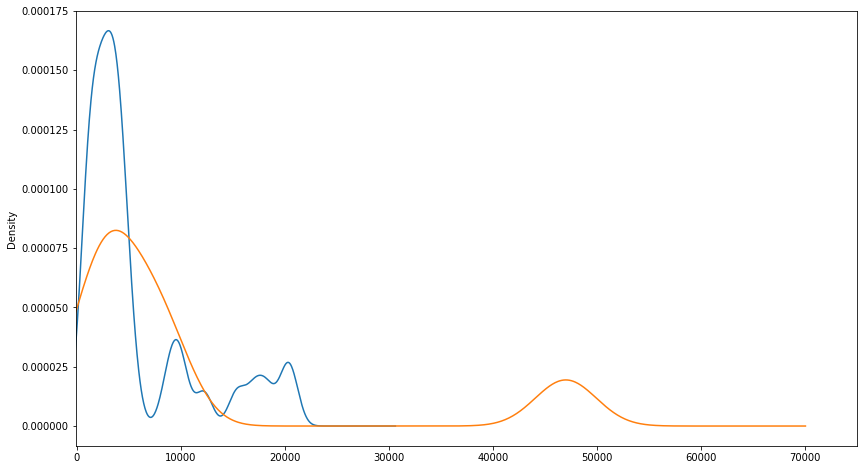

In [878]:
not_found_stage_1['Low Gamma'].plot.kde(figsize=(14,8))
found_stage_1['Low Gamma'].plot.kde(figsize=(14,8))
plt.xlim(-100, 75000)

(-100, 75000)

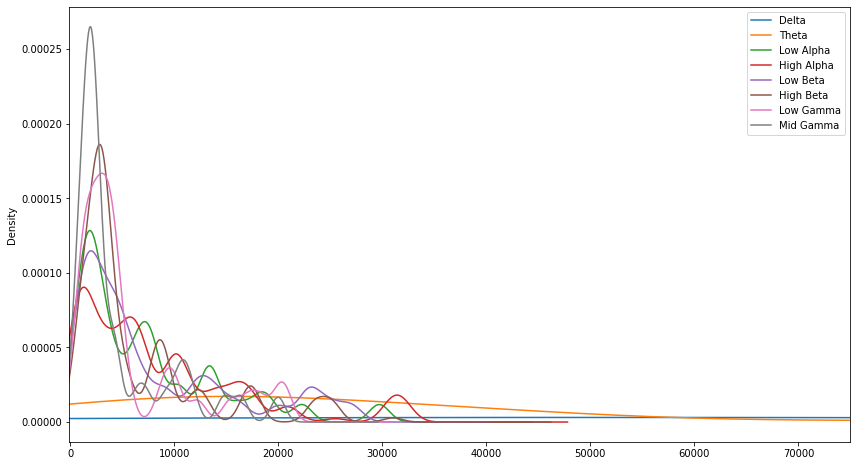

In [897]:
get_brainwaves(not_found_stage_1).plot.kde(figsize=(14,8))
plt.xlim(-100, 75000)

(-100, 75000)

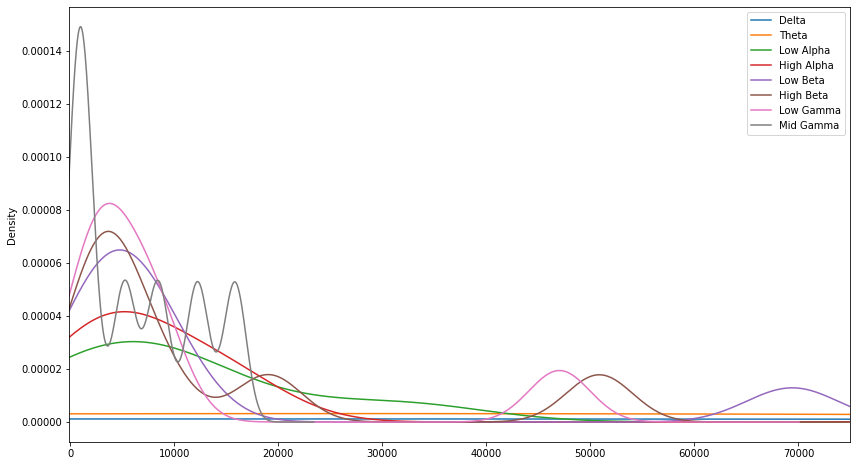

In [898]:
get_brainwaves(found_stage_1).plot.kde(figsize=(14,8))
plt.xlim(-100, 75000)

### Trial 2

In [886]:
trial2 = epoched_trials[1]

In [883]:
not_found_stage_2 = trial2.loc[trial2['Event']==0]
found_stage_2 = trial2.loc[trial2['Event']==1]

(-100, 50000)

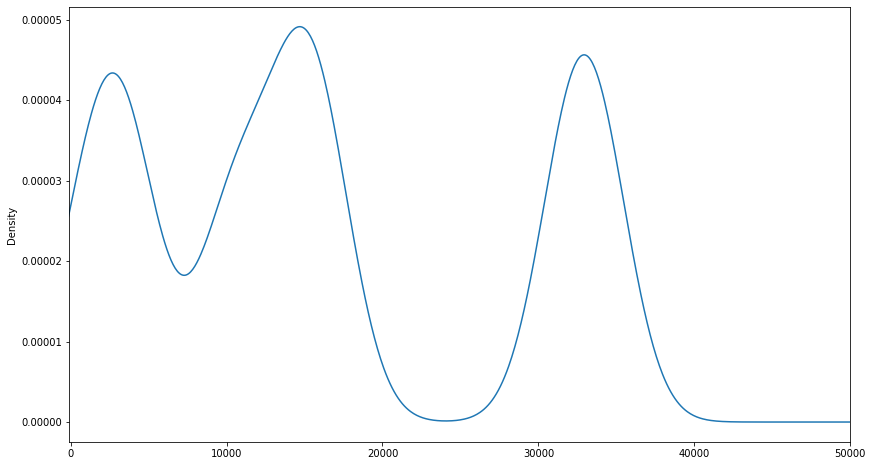

In [888]:
#cece solved it too fast so there was no 'not-found' stage for this trial

#not_found_stage_2['Low Gamma'].plot.kde(figsize=(14,8))
found_stage_2['Low Gamma'].plot.kde(figsize=(14,8))
plt.xlim(-100, 50000)